In [1]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [2]:
from OldQuantumWalkModule import operators as op
from OldQuantumWalkModule.oneDimQW import *
from OldQuantumWalkModule.berry import *
from OldQuantumWalkModule.plotting import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import pi
from numpy.linalg import eig
from scipy.linalg import expm
from sympy import *

In [3]:
import ipywidgets as widgets
from ipywidgets import interact

In [4]:
sns.set_style("darkgrid")

In [5]:
def msigma(i : int) -> Matrix:
    if i == 1:
        return Matrix( [[0, 1], [1, 0]])
    elif i == 2:
        return Matrix( [[0, -I], [I, 0]])
    elif i == 3:    
        return Matrix( [[1, 0], [0, -1]])
    else:
        raise ValueError("Invalid index for Pauli matrix. Must be 1, 2, or 3.")

In [6]:
k,nx,ny,nz = symbols('k,n_{x},n_{y},n_{z}',Reals = True)
th1,th2 = symbols('theta,phi',Reals = True)

Id = Matrix([
    [1,0],
    [0,1]
])

Sp = exp(-I*k*(Id + msigma(3))/2)
Sm = exp(I*k*(Id-msigma(3))/2) 
C = lambda th : exp(-I * (nx * msigma(1) + ny * msigma(2) + nz * msigma(3))*th)

U = Sp * C(th1) * Sm * C(th2)


lhsE_ = simplify(simplify(U).subs({nx**2+ny**2+nz**2 : 1,nx**2+ny**2 : 1-nz**2}).subs({nx : 0 , ny : 1 , nz : 0})).subs(
    {1-exp(2*I*th1): 2*I*exp(I*th1)*sin(th1),
     1+exp(2*I*th1): 2*exp(I*th1)*cos(th1),
     1-exp(2*I*th2): 2*I*exp(I*th2)*sin(th2),
     1+exp(2*I*th2): 2*exp(I*th2)*cos(th2),
      })

In [7]:
Energy_analitycal = collect(expand(simplify((lhsE_[0]+lhsE_[1]))),exp(I*k))
Energy_analitycal = lambdify(list(Energy_analitycal.free_symbols), Energy_analitycal, modules='numpy')

In [8]:
dim = 50
coin_dict = {"th1" : pi/11, "th2" : -pi/4 , "n" : [0,1,0]}
init_state_dict = {"x0" : dim//2, "a" : 1, "b" : 1}
steps = 100

model = ss_one_dim_QW(dim,coin_dict,**init_state_dict)

In [9]:
U_k = model.momentum_U()
En = - np.angle(eig(U_k)[0])

Ep, Em = En[En > 0], En[En < 0]
k = (np.arange(0,dim)-dim//2)*(2*pi/dim)

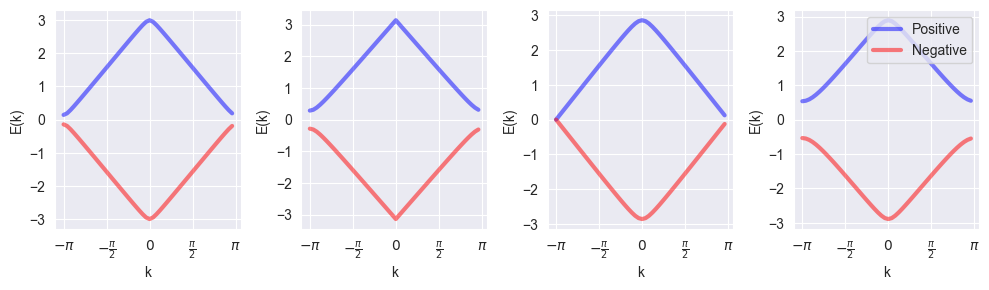

In [10]:
th2 = pi/11

fig = plt.figure(figsize = (10,3))
x_tick = [-3.14, -1.57, 0, 1.57, 3.14]
x_labs = [r'$-\pi $',r'$-\frac{\pi}{2}$', r'$0$',r'$\frac{\pi}{2}$',r'$\pi$']
ths = [(0, th2), (pi/11, th2), (-pi/11 + 0.0001,th2), (pi/4, th2)]

for i, (th1,th2) in enumerate(ths):

    ax = fig.add_subplot(1,4,i+1)

    coin_dict = {"th1" : th1, "th2" : th2 , "n" : [0,1,0]}
    model = ss_one_dim_QW(dim,coin_dict,**init_state_dict)
    U_k = model.momentum_U()
    En = - np.angle(eig(U_k)[0])
    Ep, Em = En[En > 0], En[En < 0]
    k = (np.arange(0,dim)-dim//2)*(2*pi/dim)

    ax.plot(k,Ep,color="blue",alpha=0.5, label = "Positive", lw = 3)
    ax.plot(k,Em,color="red",alpha=0.5, label = "Negative", lw = 3)
    ax.set_xlabel("k")
    ax.set_ylabel(r"E(k)")
    plt.xticks(x_tick, x_labs)
    if  i == 3:
        plt.legend(loc = "upper right")

plt.tight_layout()
fig.savefig("Images/DispersiveRel.pdf",format= "pdf",bbox_inches = "tight")
#plt.show()

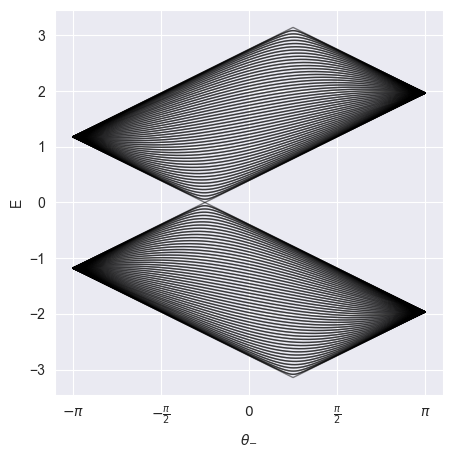

In [19]:
th1 = pi/4
th2 = np.arange(-pi,pi,0.01)
Energies_th1 = []

for i,th2_ in enumerate(th2):
    coin_dict = {"th1" : th1, "th2" : th2_ , "n" : [0,1,0]}
    model_eig = ss_one_dim_QW(dim,coin_dict,**init_state_dict)
    E_ = eig(model_eig.momentum_U())[0]
    E_ = np.sort(- np.angle(E_) )
    Energies_th1.append(E_)

Energies_th1 = np.array(Energies_th1)

sns.set_style("darkgrid")
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
x_tick = [-3.14, -1.57, 0, 1.57, 3.14]
x_labs = [r'$-\pi $',r'$-\frac{\pi}{2}$', r'$0$',r'$\frac{\pi}{2}$',r'$\pi$']

for i in range(Energies_th1.shape[1]):
    ax.plot(th2,Energies_th1[:,i],color = "black",alpha = 0.5, lw = 1)
ax.set_xlabel(r"$\theta_{-}$")
ax.set_ylabel(r"E")
plt.xticks(x_tick, x_labs)
fig.savefig("Images/EnergiesSpecter.pdf",format= "pdf",bbox_inches = "tight")



In [12]:
dim = 40

bp = BerryPhase()

def berry_phase(th1,th2):
    coin_dict = {
        "th1" : th1,
        "th2" : th2,
        "n" : [0,1,0]
    }
    model = ss_one_dim_QW(dim,coin_dict)
    return bp.Calculate(model)

th_1 = np.arange(-2*np.pi,2*np.pi,0.1)
th_2 = np.arange(-2*np.pi,2*np.pi,0.1)
th_1, th_2 = np.meshgrid(th_1,th_2)

data_ans = np.vectorize(berry_phase)(th_1,th_2)

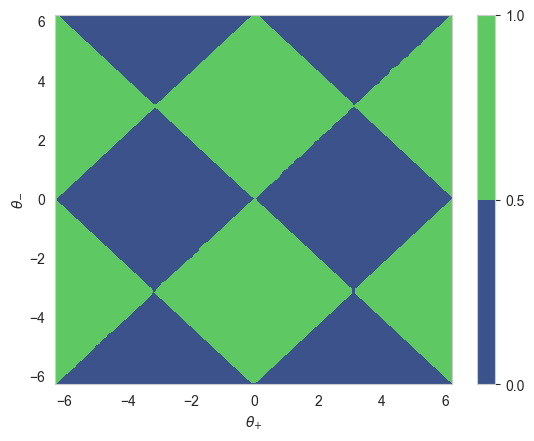

In [16]:
fig,ax = plt.subplots()

cax = ax.contourf(th_1,th_2,data_ans[0]/np.pi,cmap = "viridis", levels = 1)
fig.colorbar(cax)
ax.set_xlabel(r"$\theta_{+}$")
ax.set_ylabel(r"$\theta_{-}$")

plt.show()

/var/folders/zp/qy3s56jn3yjcjsc5rp03kr700000gn/T/ipykernel_3288/2478036351.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


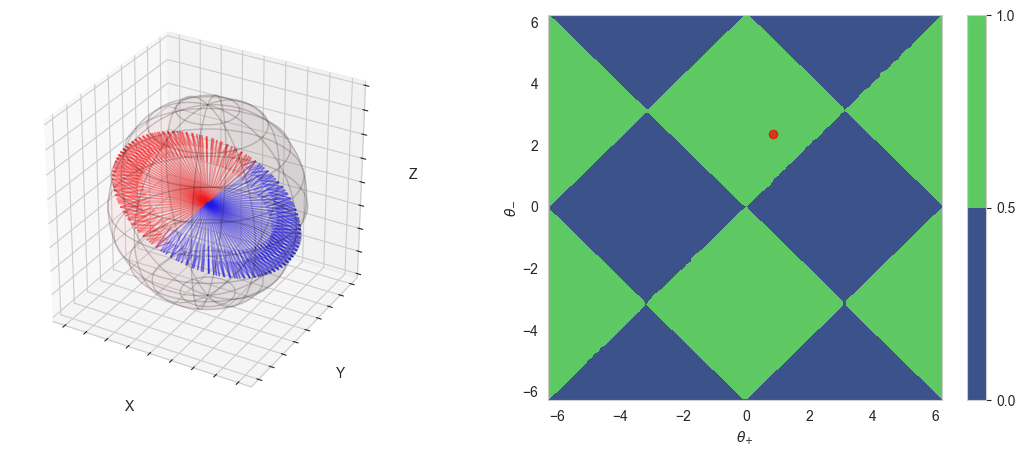

In [14]:
sns.set_style("whitegrid")

dim = 100
coin_dict = {"th1" : 3*pi/11, "th2" :3*pi/4. , "n" : [0,1,0]}
init_state_dict = {"x0" : dim//2, "a" : 1, "b" : 1}

model = ss_one_dim_QW(dim,coin_dict,**init_state_dict)
bp = BerryPhase()

ns = np.real(bp.vector_representation(model))

th1 = coin_dict["th1"]
th2 = coin_dict["th2"]

_,_,fig = berry_bloch_phase(th1,th2,ns,th_1,th_2,data_ans[0])
plt.tight_layout()
fig.savefig("Images/BerryBlochFig1.pdf",format= "pdf",bbox_inches = "tight")


/var/folders/zp/qy3s56jn3yjcjsc5rp03kr700000gn/T/ipykernel_3288/647106624.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


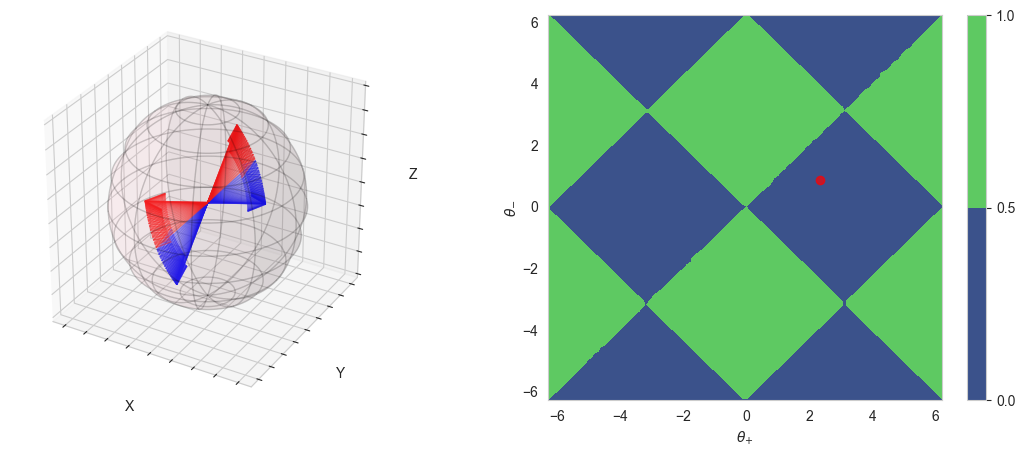

In [15]:
dim = 100
coin_dict = {"th1" : 3* pi/4, "th2" :3* pi/11 , "n" : [0,1,0]}
init_state_dict = {"x0" : dim//2, "a" : 1, "b" : 1}

model = ss_one_dim_QW(dim,coin_dict,**init_state_dict)
bp = BerryPhase()

ns = np.real(bp.vector_representation(model))

th1 = coin_dict["th1"]
th2 = coin_dict["th2"]

_,_,fig = berry_bloch_phase(th1,th2,ns,th_1,th_2,data_ans[0])
plt.tight_layout()
fig.savefig("Images/BerryBlochFig2.pdf",format= "pdf",bbox_inches = "tight")